# Project 2nd : Toxic comment classsification

## Problem statement:

In the world full of internet everybody has liberty to write and give their opinion at any social medial platform. people usually choose to write their opinion on website"s comment section and thread section but many times it has observed that rather than giving constructive advise people use this opportunity to bully or abuse others and start fighting with each other in the threads and comment section where they sometimes even give threat and insult each other .To specifically identify and restrict these type of comments internet companies are working very hardly and this competition was also held on similar topic.

## The resources used in this project

1.) https://arxiv.org/pdf/1810.04805.pdf

2.) https://huggingface.co/transformers/model_doc/bert.html

### 1.) Importing all the important libraries

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertModel , TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import os
from googletrans import *
from wordcloud import WordCloud , STOPWORDS 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 3.) Loading the data

In [6]:
data = pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv")
test_data =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv")
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test_labels = pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
test_data = test_data.merge(  test_labels ,  how='right')
test_data_new = test_data[test_data["toxic"]!= -1].reset_index(drop=True)
test_data_new.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


### 3.) check the null values in the data frames

In [9]:
print("comment_text null value   =",sum(pd.isnull(data['comment_text'])))
print("toxic comment null values =" ,sum(pd.isnull(data['toxic'])))
print("sever toxic null values   =" , sum(pd.isnull(data['severe_toxic'])))
print("obscene null values       =" , sum(pd.isnull(data['obscene'])))
print("threat null values        =" ,sum(pd.isnull(data['threat'])))
print("insult null values        =" ,sum(pd.isnull(data['insult'])))
print("identity null values      ="  ,sum(pd.isnull(data['identity_hate'])))

comment_text null value   = 0
toxic comment null values = 0
sever toxic null values   = 0
obscene null values       = 0
threat null values        = 0
insult null values        = 0
identity null values      = 0


In [10]:
print("comment_text null value   =",sum(pd.isnull(test_data_new['comment_text'])))
print("toxic comment null values =" ,sum(pd.isnull(test_data_new['toxic'])))
print("sever toxic null values   =" , sum(pd.isnull(test_data_new['severe_toxic'])))
print("obscene null values       =" , sum(pd.isnull(test_data_new['obscene'])))
print("threat null values        =" ,sum(pd.isnull(test_data_new['threat'])))
print("insult null values        =" ,sum(pd.isnull(test_data_new['insult'])))
print("identity null values      ="  ,sum(pd.isnull(test_data_new['identity_hate'])))

comment_text null value   = 0
toxic comment null values = 0
sever toxic null values   = 0
obscene null values       = 0
threat null values        = 0
insult null values        = 0
identity null values      = 0


### 4.) Visualizing data 

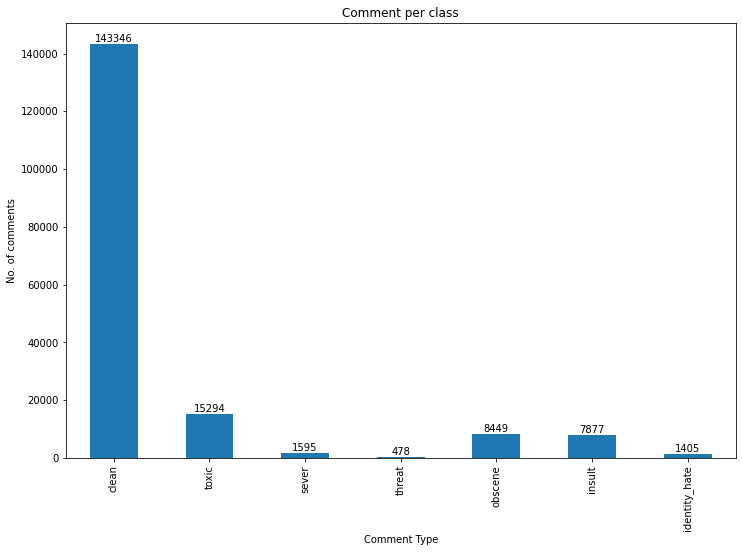

In [75]:
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

clean = len(data[(data["toxic"]==0) & (data["severe_toxic"]==0) & (data["obscene"]==0) & (data["threat"]==0) &(data["insult"]==0) & (data["identity_hate"]==0)]) 
toxic = len(data[data["toxic"]==1])
sever =  len(data[data["severe_toxic"]==1])
threat = len(data[data["threat"]==1]) 
obscene = len(data[data["obscene"]==1])
insult = len(data[data["insult"]==1])
identity_hate = len(data[data["identity_hate"]==1])
fr = [clean , toxic , sever , threat ,obscene , insult , identity_hate]

freq_series = pd.Series(fr)
x_labels = ["clean" , "toxic" , "sever" , "threat" ,"obscene" , "insult" , "identity_hate"]
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Comment per class')
ax.set_xlabel("Comment Type")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(x_labels)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### observation:
    
   1.) The data is highly imbalanced in nature and some of the points are very less like threat and identity hate.

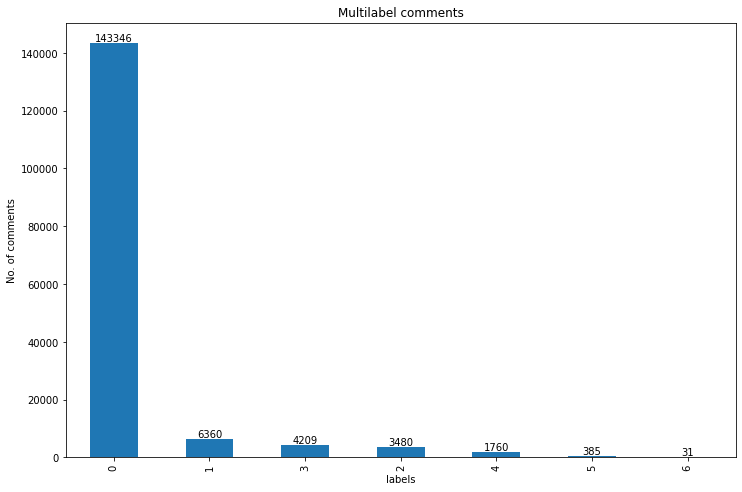

In [28]:
x = data[["toxic" , "severe_toxic"  ,"obscene" , "threat" , "insult" , "identity_hate"]].sum(axis = 1).value_counts()#it written a dictionary
key = x.keys()
value = x.values

fr = pd.Series(value)
plt.figure(figsize=(12, 8))
ax = fr.plot(kind='bar')
ax.set_title('Multilabel comments')
ax.set_xlabel("labels")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(key)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### Observation:

  1.) Most of the labels are sigle labeled in the data set.
  
  2.) Only 31 points are there which has all the three labesl.
   

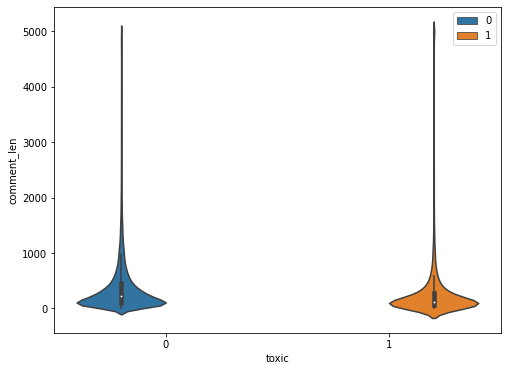

In [46]:
data["comment_len"] = [len(i) for i in data.comment_text.values]
plt.figure(figsize=(8,6))
ax = sns.violinplot(x="toxic", y="comment_len", data=data , hue = "toxic")
plt.legend()
plt.show()

### Observation:
    
   1.) Boht the toxic and clean comments have equal lengths in the distribution.
   
   2.) The 75percentile clean comments have lenght nearly equal to the 200-250 words.
   
   3.) The 75percentile toxic comments have lenght nearly equal to the 200-250 words.

### 5.) Visualizing word cloud of each column:

In [29]:
toxic_data = data[data["toxic"]==1]

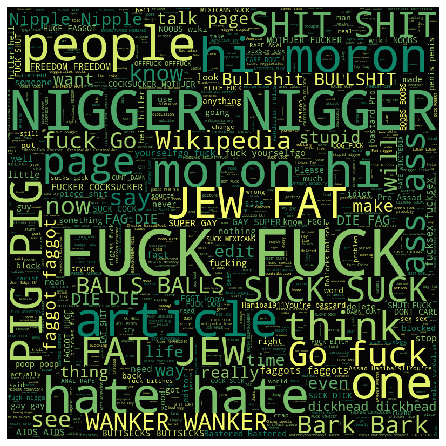

In [30]:
#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', max_words=2000,
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
#plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

In [27]:
toxic_data = data[data["severe_toxic"]==1]

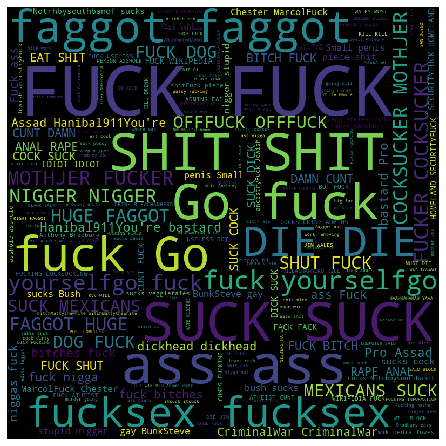

In [28]:
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [25]:
toxic_data = data[data["obscene"]==1]

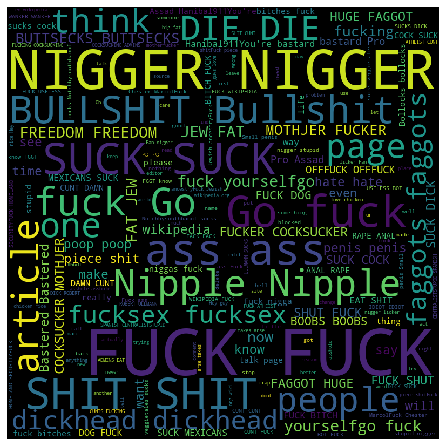

In [26]:
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [23]:
toxic_data = data[data["threat"]==1]

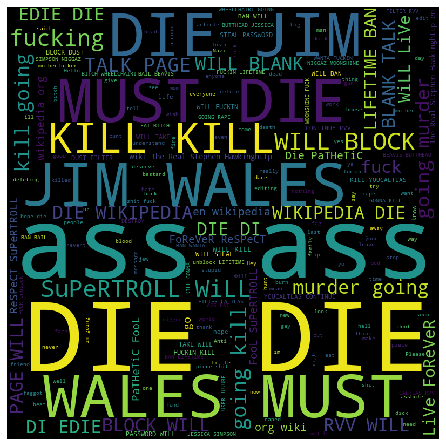

In [24]:
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [21]:
toxic_data = data[data["insult"]==1]

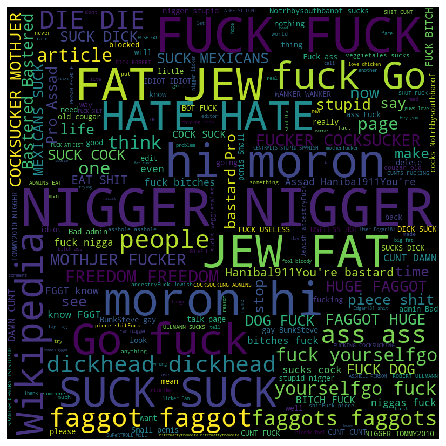

In [22]:
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [19]:
toxic_data = data[data["identity_hate"]==1]

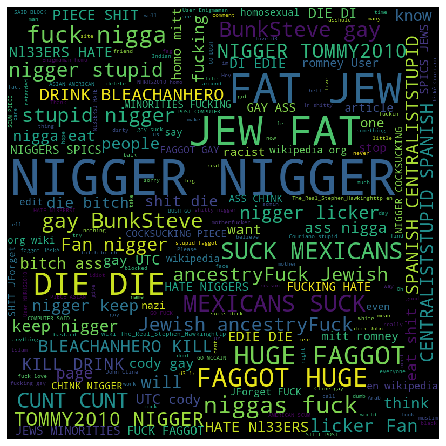

In [20]:
str1 = ''.join(toxic_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [14]:
clean_data = data[(data["toxic"]==0)&(data["severe_toxic"]==0)&(data["obscene"]==0)&(data["insult"]==0)&(data["threat"]==0)&(data["identity_hate"]==0)]

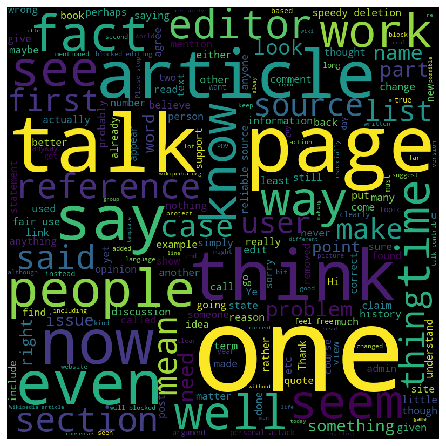

In [18]:
str1 = ''.join(clean_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Observation:

  1.) Most of the words in toxic are very abusive in nature.
  
  2.) On the other hand clean comments have all the constructive and positive approch.

### 6.) Extending the data set.

We saw a new way of extending the data set . This idea was proposed by the (Pavel Ostyakov) https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/48038, in this we can leverage the idea of google translator. The example of this is given below.

In [26]:
translator = Translator()
encode = translator.translate(data.comment_text.values[0] , dest='fr').text
decode = translator.translate(encode , dest='en').text
print(data.comment_text.values[0])
print(decode)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Explanation
Why have the changes made under my Hardcore Metallica Fan username been canceled? They were not vandalism, just the closing of some GAs after having voted in the FAC of New York Dolls. And don't delete the template from the talk page, because I'm now retired.


In [ ]:
translator = Translator()

train_es = []
train_de = []
train_fr = []

for i in range(len(data.comment_text.values)):
    encode_es = translator.translate(data.comment_text.values[0] , dest='es').text
    decode_es = translator.translate(encode_es , dest='en').text
    train_es.append(decode_es)

    encode_de = translator.translate(data.comment_text.values[0] , dest='de').text
    decode_de = translator.translate(encode_de , dest='en').text
    train_de.append(decode_de)

    encode_fr = translator.translate(data.comment_text.values[0] , dest='fr').text
    decode_fr = translator.translate(encode_fr , dest='en')
    train_fr.append(decode_fr)


In [16]:
train_es =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_es.csv")
train_de =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_de.csv")
train_fr =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_fr.csv")
print(len(train_es))
print(len(train_de))
print(len(train_fr))

159571
159571
159571


### 7.) Creating the new data set with higher no. of data points

In [17]:
new_train =  pd.concat([data ,train_fr  ,train_es ,train_de , test_data_new])
new_train = shuffle(new_train)
print(len(new_train))

702262


In [23]:
train_comment = new_train["comment_text"].values
test_comment  = test_data["comment_text"].values

### 8.) Loading the bert tokenizer and encoding the text in input format

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [34]:
padded_ids_train = []
mask_ids_train = []

for i in tqdm(range(len(train_comment))):
    encoding = tokenizer.encode_plus(train_comment[i]  , max_length = 128 , pad_to_max_length = True  ,do_lower_case = False)
    input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"] 
  #if len(input_ids) < max_len:
    #padded_ = [0]*((max_len) - len(input_ids))
    padded_ids_train.append(input_ids)
  #padded_ids.extend(padded_)
    mask_ids_train.append(attention_id)

100%|██████████| 702262/702262 [12:02<00:00, 971.62it/s] 


In [21]:
padded_ids_test = []
mask_ids_test = []

for i in tqdm(range(len(test_comment))):
    encoding = tokenizer.encode_plus(test_comment[i]  , max_length = 128 , pad_to_max_length = True , do_lower_case = False )
    input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"]
  #if len(input_ids) < max_len:
    #padded_ = [0]*((max_len) - len(input_ids))
    padded_ids_test.append(input_ids)
  #padded_ids.extend(padded_)
    mask_ids_test.append(attention_id)

100%|██████████| 153164/153164 [02:37<00:00, 974.24it/s]


In [ ]:
#train_array = np.array(new_df["toxic"].values)
y_train = new_train.drop(["id" ,"comment_text"] , axis=1)

#test_array = np.array(test_data_new["toxic"].values)

In [35]:
train_id = np.array(padded_ids_train)
train_mask = np.array(mask_ids_train)

test_id = np.array(padded_ids_test)
test_mask = np.array(mask_ids_test)

print(train_id.shape , test_id.shape)
print(train_mask.shape , test_mask.shape)

(702262, 128) (153164, 128)
(702262, 128) (153164, 128)


### Model 1.) 

### Architecture:

In [36]:
input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)

input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

output  = model([input_1 , input_2] , training = True )

answer = tf.keras.layers.Dense(6 , activation = tf.nn.sigmoid )(output[0])

model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [answer])

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         109483778   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6)            18          tf_bert_for_sequence_classi

In [46]:
%load_ext tensorboard

In [ ]:
!rm -rf /gdrive/My Drive/logs/

### Creating path for saving the model and tensorboard

In [ ]:
log_dir = "/gdrive/My Drive/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath = "/gdrive/My Drive/final_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                                  monitor='val_auc',
                                  verbose=1,
                                  save_best_only=True , mode = "max" , save_weights_only = True)

In [38]:
auc_score = AUC(multi_label=True)
model.compile(optimizer = Adam(lr = 3e-5),
                loss = tf.keras.losses.binary_crossentropy,
             metrics = [ auc_score])

In [ ]:
model.fit([train_id , train_mask] , y_train,
          validation_split = 0.1 , batch_size = 32, 
          epochs=4, callbacks = [tensorboard_callback , checkpoint]
)

In [39]:
%tensorboard --logdir "/gdrive/My Drive/logs"

### Train loss:

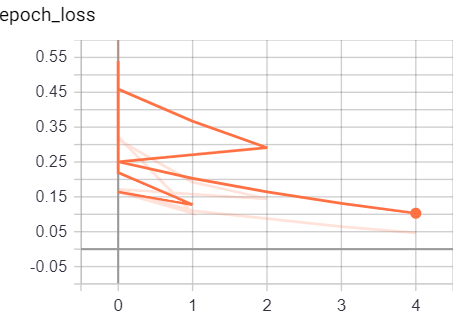

In [3]:
from IPython.display import Image
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_1 train loss.PNG")

### CV loss:

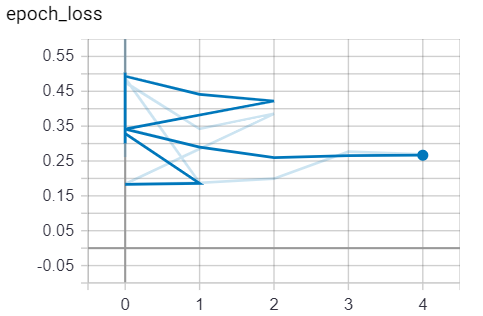

In [6]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_1 val loss.PNG")

### Model prediction and saving the output 

In [ ]:
a = model.predict([test_id , test_mask])
sub = pd.DataFrame(a , columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
sub["id"] = test_data["id"].values
sub.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.996859,0.249085,0.988158,0.020886,0.978657,0.226216,00001cee341fdb12
1,0.000981,0.000043,0.000692,0.000128,0.000117,0.000079,0000247867823ef7
2,0.015035,0.000207,0.003353,0.000754,0.002331,0.000990,00013b17ad220c46
3,0.000158,0.000004,0.000095,0.000014,0.000013,0.000004,00017563c3f7919a
4,0.000236,0.000008,0.000170,0.000023,0.000025,0.000007,00017695ad8997eb


In [ ]:
result = sub[["id",'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
result.to_csv("/gdrive/My Drive/ninth_submission.csv" ,index=False)
result.tail()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,0.496643,0.001046,0.182512,0.000676,0.031268,0.001175
153160,fffd7a9a6eb32c16,0.000931,0.000030,0.000584,0.000143,0.000087,0.000072
153161,fffda9e8d6fafa9e,0.000181,0.000004,0.000116,0.000018,0.000012,0.000005
153162,fffe8f1340a79fc2,0.000768,0.000047,0.000810,0.000115,0.000069,0.000082
153163,ffffce3fb183ee80,0.620240,0.004997,0.381507,0.002538,0.113429,0.006729


### Modle 2.)

### Architecture :

In [41]:
def creat_model():
  
        input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)

        input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)

        model = TFBertModel.from_pretrained('bert-base-uncased')

        output , pooled_out  = model([input_1 , input_2] , training = True )

        x = tf.reshape(pooled_out , (-1 , pooled_out.shape[1]))

        dense_1 = tf.keras.layers.Dense(768   , activation= tf.nn.relu)(x)

        drop_1 = tf.keras.layers.Dropout(0.1)(dense_1)

        answer = tf.keras.layers.Dense(6 , activation = tf.nn.sigmoid)(drop_1)

        model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [answer])

        return model

In [42]:
model = creat_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 128, 768), ( 109482240   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None, 768)]        0           tf_bert_model_1[0][1]      

### Creating path for saving the model and tensorboard

In [ ]:
log_dir = "/gdrive/My Drive/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath = "/gdrive/My Drive/final_model3.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                                  monitor='val_auc',
                                  verbose=1,
                                  save_best_only=True , mode = "max" , save_weights_only = True)

In [43]:
auc_score = AUC(multi_label=True)
model.compile(optimizer = Adam(lr = 3e-5),
                loss = tf.keras.losses.binary_crossentropy,
             metrics = [ auc_score])

In [ ]:
model.fit([train_id , train_mask] , y_train,
          validation_split = 0.1 , batch_size = 32, 
          epochs=4, callbacks = [tensorboard_callback , checkpoint]
)

### Model prediction and saving the output


In [ ]:
b = model.predict([test_id , test_mask])
sub = pd.DataFrame(b , columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
sub["id"] = test_data["id"].values
result = sub[["id",'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
result.to_csv("/gdrive/My Drive/13th_submission.csv" ,index=False)

In [ ]:
%tensorboard --logdir "/gdrive/My Drive/logs"

### Train loss:

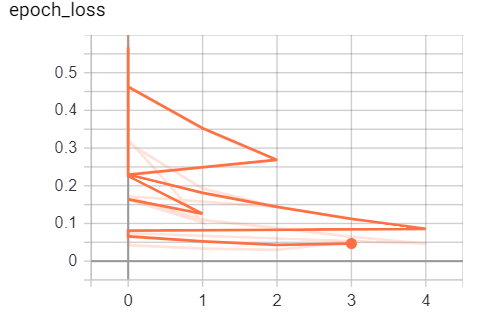

In [5]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_2 train loss.PNG")

### CV loss:

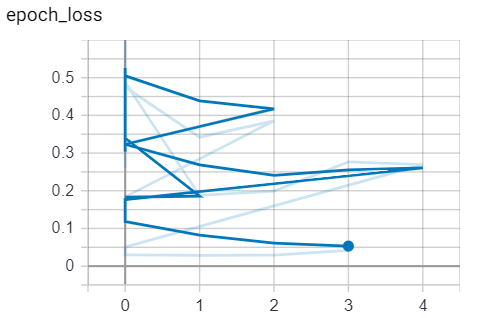

In [4]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_2 val loss.PNG")

### Final result:

In [8]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model name", "Private_score", "public_score"]
x.add_row(["Model_1"           , 0.98139, 0.98209 ])
x.add_row(["Model_2"           , 0.98951, 0.98931 ])
x.add_row(["Model_1 + Model_2" , 0.98971, 0.98993 ])

print(x)

+-------------------+---------------+--------------+
|     Model name    | Private_score | public_score |
+-------------------+---------------+--------------+
|      Model_1      |    0.98139    |   0.98209    |
|      Model_2      |    0.98951    |   0.98931    |
| Model_1 + Model_2 |    0.98971    |   0.98993    |
+-------------------+---------------+--------------+
